[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Please upload your ZIP:


Saving latvian_communist_leaflets_1934-1936.zip to latvian_communist_leaflets_1934-1936.zip
ZIP uploaded: latvian_communist_leaflets_1934-1936.zip
Flattened: moved 0 .txt files to /content/corpus
TXT files found: 203
Parsed 203 leaflets.
Sentences: 10546 | Months: 33


/tmp/ipython-input-3878271373.py:145: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(month_df['month'], rotation=45)


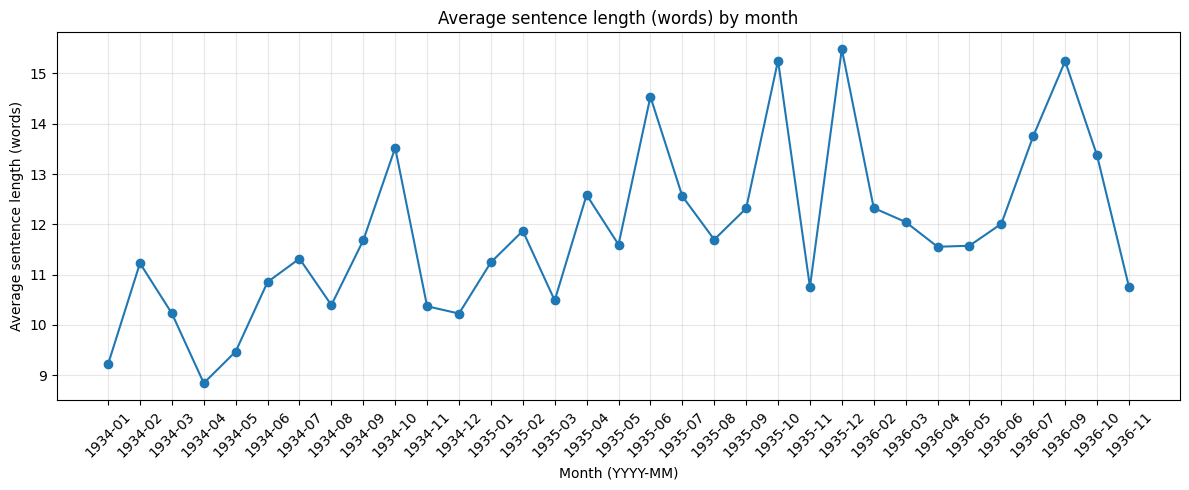

✅ Saved: sentence_word_counts.csv, monthly_avg_sentence_length.csv, monthly_avg_sentence_length.png


In [1]:
# === Latvian Communist Leaflet Corpus: Sentence-length analysis from ZIP upload ===

!pip install --quiet nltk python-dateutil
import nltk, re, os, io, zipfile, glob, shutil
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from dateutil import parser as dateparser
from datetime import datetime
from google.colab import files

nltk.download('punkt')
nltk.download('punkt_tab')

# === 1. Upload ZIP ===
folder_path = '/content/corpus'
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
os.makedirs(folder_path, exist_ok=True)

print("Please upload your ZIP:")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("❌ ZIP not uploaded — please try again.")

zip_name = next(iter(uploaded.keys()))
print("ZIP uploaded:", zip_name)

# === 2. Extract ===
with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as zf:
    zf.extractall(folder_path)

# Flatten (move .txt up if nested)
def flatten_txt(root='/content/corpus'):
    moved = 0
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith('.txt'):
                src = os.path.join(dirpath, fn)
                dst = os.path.join(root, fn)
                if src != dst and not os.path.exists(dst):
                    shutil.move(src, dst)
                    moved += 1
    for dirpath, dirnames, filenames in list(os.walk(root, topdown=False)):
        if dirpath != root and not dirnames and not filenames:
            os.rmdir(dirpath)
    print(f"Flattened: moved {moved} .txt files to {root}")

flatten_txt(folder_path)
txt_files = sorted(glob.glob(os.path.join(folder_path, "*.txt")))
print(f"TXT files found: {len(txt_files)}")
if not txt_files:
    raise SystemExit("❌ No .txt files found in ZIP!")

# === 3. Parse leaflet files ===
def parse_leaflet_file(path):
    meta = {}
    text_lines, in_text = [], False
    with open(path, 'r', encoding='utf-8', errors='replace') as f:
        for raw in f:
            line = raw.rstrip('\n')
            if not in_text:
                m = re.match(r'^(\w+):\s*(.*)$', line)
                if m:
                    key, val = m.group(1).strip().lower(), m.group(2).strip()
                    if key.startswith('text'):
                        in_text = True
                        if val:
                            text_lines.append(val)
                    else:
                        meta[key] = val
            else:
                text_lines.append(line)
    text = "\n".join(text_lines).strip()

    # find date
    date_raw = (meta.get('date') or '').strip()
    if date_raw:
        date_raw = date_raw.strip(' []…')
    else:
        fname = meta.get('file_name') or os.path.basename(path)
        m = re.search(r'(19\d{2}(?:-\d{2}(?:-\d{2})?)?)', fname)
        date_raw = m.group(1) if m else None

    return {
        'file_name': meta.get('file_name') or os.path.basename(path),
        'date_raw': date_raw,
        'text': text
    }

docs = [parse_leaflet_file(p) for p in txt_files]
print(f"Parsed {len(docs)} leaflets.")

# === 4. Sentence split & word count ===
from nltk.tokenize import sent_tokenize

def split_sentences(text):
    parts = re.split(r'(?<=[\.\!\?…])\s+', text.replace('\r', '\n'))
    parts = [p.strip() for p in parts if p and not p.isspace()]
    if len(parts) <= 1:
        parts = sent_tokenize(text)
    return parts

def count_words(sentence):
    s = sentence.strip()
    s = re.sub(r'^[\s\W]+|[\s\W]+$', '', s)
    if not s: return 0
    return len(re.findall(r"[A-Za-zĀ-žĀĒĪŪāēīūĶĻŅŖČĢŠŽčģšž0-9_\-']+", s, flags=re.UNICODE))

def iso_month_from_raw(date_raw):
    if not date_raw: return None
    try:
        dt = dateparser.parse(date_raw, default=datetime(1900,1,1))
        return dt.strftime('%Y-%m')
    except:
        m = re.search(r'(19\d{2})-(\d{2})', date_raw)
        return f"{m.group(1)}-{m.group(2)}" if m else None

# === 5. Analyze ===
rows = []
per_month = defaultdict(list)
for d in docs:
    month = iso_month_from_raw(d.get('date_raw'))
    sents = split_sentences(d.get('text') or '')
    for s in sents:
        c = count_words(s)
        if c > 0:
            rows.append({'file_name': d['file_name'], 'month': month, 'sentence': s, 'words': c})
            if month:
                per_month[month].append(c)

df_sents = pd.DataFrame(rows)
month_df = pd.DataFrame(
    [{'month': m, 'avg_sentence_length': sum(v)/len(v), 'n_sentences': len(v)} for m,v in per_month.items()]
).sort_values('month') if per_month else pd.DataFrame(columns=['month','avg_sentence_length','n_sentences'])

print("Sentences:", len(df_sents), "| Months:", len(month_df))

# === 6 Plot ===
if month_df.empty:
    print("⚠️ No monthly data (maybe missing dates?).")
else:
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(month_df['month'], month_df['avg_sentence_length'], marker='o')
    ax.set_xticklabels(month_df['month'], rotation=45)
    ax.set_xlabel('Month (YYYY-MM)')
    ax.set_ylabel('Average sentence length (words)')
    ax.set_title('Average sentence length (words) by month')
    ax.grid(alpha=0.3)
    fig.tight_layout()
    fig.savefig('monthly_avg_sentence_length.png', dpi=200)  # save PNG
    plt.show()
    plt.close(fig)

df_sents.to_csv('sentence_word_counts.csv', index=False)
month_df.to_csv('monthly_avg_sentence_length.csv', index=False)
print("✅ Saved: sentence_word_counts.csv, monthly_avg_sentence_length.csv, monthly_avg_sentence_length.png")